# MICrONS NWB tutorial

This tutorial demonstrates how to access the [MICrONS functional data](https://dandiarchive.org/dandiset/000402/draft) using `dandi`.

The functional data from the [MICrONS project](https://www.microns-explorer.org/cortical-mm3) contains calcium imaging recorded from multiple cortical visual areas and behavioral measurements while a mouse viewed natural movies and parametric stimuli.


#### Contents:
* [Streaming NWB files](#stream-nwb)
* [Access data and metadata](#access-nwb)
* [View NWB files with NWBWidgets](#view-nwb)
* [Downloading NWB files](#download-nwb)

## Streaming NWB files <a class="anchor" id="stream-nwb"></a>

This section demonstrates how to access the files on DANDI without downloading them.

Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from `PyNWB`.

The `DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive. 

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "000402"
file_path = "sub-17797/sub-17797_ses-9+4_behavior+image+ophys.nwb" # file size ~67GB

# Get the location of the file on DANDI
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

Create a virtual filesystem using `fsspec` which will take care of requesting data from the S3 bucket whenever data is read from the virtual file.

In [2]:
from fsspec.implementations.cached import CachingFileSystem
from fsspec import filesystem
from h5py import File
from pynwb import NWBHDF5IO


# Create a virtual filesystem based on the http protocol and use caching to save accessed data to RAM.
file_system = CachingFileSystem(
    fs=filesystem("http"),
    cache_storage="nwb-cache",  # Local folder for the cache
)

# Open the file with NWBHDF5IO
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Access data and metadata <a class="anchor" id="access-nwb"></a>

This section demonstrates how to access the data in the NWB files.


### Subject

The `nwbfile.subject` field holds information about the experimental subject, such as age (in [ISO 8601 Duration format](https://en.wikipedia.org/wiki/ISO_8601#Durations)), sex, and species in latin binomial nomenclature.

In [3]:
# Access the subject metadata
nwbfile.subject

subject pynwb.file.Subject at 0x140344636602448
Fields:
  age: P75D/P81D
  sex: M
  species: Mus musculus
  subject_id: 17797

### Trials

#### Clip

This stimulus condition is composed of 10 second clips. The trials for this condition can be accessed as `nwbfile.intervals["Clip"]`.

In [4]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            # View the description for this stimulus type
            print(nwbfile.intervals["Clip"].description)
            # Load the data into a dataframe object
            clip_dataframe = nwbfile.intervals["Clip"].to_dataframe()         

Composed of 10 second clips from cinematic releases, Sports-1M dataset, or custom rendered first person POV videos in 3D environment in Unreal Engine.


In [5]:
clip_dataframe

,start_time,stop_time,stimulus_type,condition_hash,movie_name,short_movie_name,duration
id,,,,,,,
4,269.464581,279.431084,stimulus.Clip,okYfMyn8qc2ClgvpS7WG,2009 Skijoring Event in Whitefish Montana (par...,sports1m,10.0
5,279.531081,289.497598,stimulus.Clip,NHlF8hOkZ6psFRIVhB6N,ancienttomb_107-1-4-70-0_54.165.28.255,Rendered,10.0
6,289.597593,299.564101,stimulus.Clip,AxNNo310kAl9uUSr+hXS,medievalsewer_009-1-6-70-0_107.23.36.15,Rendered,10.0
7,299.664089,309.630596,stimulus.Clip,mjtZRmGqaXCHGB59txoI,Powaqqatsi: Life in Transformation (1988),Cinematic,10.0
8,309.730601,319.697093,stimulus.Clip,W50xYLSTlUixv1tOfuSJ,2011 Boulder Cup Cyclocross Elite Women,sports1m,10.0
...,...,...,...,...,...,...,...
459,5229.733599,5239.700111,stimulus.Clip,BmdZ8rRGTB6ueDkz+Kr/,shintonight_095-1-13-70-0_54.89.40.102,Rendered,10.0
460,5239.800111,5249.766615,stimulus.Clip,WslKzH0v/OEqVTLiw468,2011 June 14 Midweek MTB Corner Canyon XC Moun...,sports1m,10.0
461,5249.866617,5259.833112,stimulus.Clip,eNJ7fFpiRbVfX48l845P,2011 August 2 Midweek MTB Solitude XC Mountain...,sports1m,10.0


#### Monet2

This stimulus condition is generated from smoothened Gaussian noise and a global orientation and direction component. The trials for this condition can be accessed as `nwbfile.intervals["Monet2"]`.

In [6]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()

            # View the description for this stimulus type
            print(nwbfile.intervals["Monet2"].description)
            # Load the data into a dataframe object
            monet2_dataframe = nwbfile.intervals["Monet2"].to_dataframe()

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Generated from smoothened Gaussian noise and a global orientation and direction component.


In [7]:
monet2_dataframe.head()

,start_time,stop_time,stimulus_type,condition_hash,rng_seed,duration,blue_green_saturation,pattern_width,pattern_aspect,temp_kernel,temp_bandwidth,ori_coherence,ori_fraction,ori_mix,num_directions
id,,,,,,,,,,,,,,,
0,209.198904,224.181996,stimulus.Monet2,WD0uyxvusJmVxfeKu9mZ,1.0,15.0,0,72,1.7,hamming,4.0,2.5,1.0,1.0,16
1,224.281990,239.265071,stimulus.Monet2,kEq0YeYOSSBtM1ZkWA1a,4.0,15.0,0,72,1.7,hamming,4.0,2.5,1.0,1.0,16
2,239.348411,254.331497,stimulus.Monet2,clN4ica4q7huSnWVFTFi,3.0,15.0,0,72,1.7,hamming,4.0,2.5,1.0,1.0,16
3,254.414823,269.397922,stimulus.Monet2,NnOFXtdjpcasByEfeJf9,2467.0,15.0,0,72,1.7,hamming,4.0,2.5,1.0,1.0,16
50,752.506706,767.489783,stimulus.Monet2,yv/S61fYnDSQcA9J6Nk8,7.0,15.0,0,72,1.7,hamming,4.0,2.5,1.0,1.0,16


#### Trippy

The stimulus table for the cosine of a smoothened noise phase movie can be accessed as `nwbfile.intervals["Trippy"]`.

In [9]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            # View the description for this stimulus type
            print(nwbfile.intervals["Trippy"].description)
            # Load the data into a dataframe object
            trippy_dataframe = nwbfile.intervals["Trippy"].to_dataframe()

The stimulus table for the cosine of a smoothened noise phase movie.


In [10]:
trippy_dataframe.head()

,start_time,stop_time,stimulus_type,condition_hash,rng_seed,texture_height,texture_width,duration,xnodes,ynodes,up_factor,temp_freq,temp_kernel_length,spatial_freq
id,,,,,,,,,,,,,,
10,329.863606,344.846688,stimulus.Trippy,e9eVr8Agj8TsRJR3XEBg,1007.0,90,160,15.0,12,6,24,4.0,61,0.08
11,344.930015,359.913113,stimulus.Trippy,tRgm529SPpQspr220FRm,2.0,90,160,15.0,12,6,24,4.0,61,0.08
12,359.996445,374.979541,stimulus.Trippy,hhWRsNy4ljt4M1PtvZ3u,6.0,90,160,15.0,12,6,24,4.0,61,0.08
13,375.062862,390.045950,stimulus.Trippy,ZJvulWBItHtLlDVkIntm,8.0,90,160,15.0,12,6,24,4.0,61,0.08
94,1235.298793,1250.281879,stimulus.Trippy,EhwIk1vM51LHZPE6xFZX,5.0,90,160,15.0,12,6,24,4.0,61,0.08


### Stimulus movie data

The visual stimulus composed of parametric stimuli and natural movie clips.

The movie data is stored in an `ImageSeries` object.

The frames are stored in a 4D array where the first dimension is time (frame), the second and third dimenion represents the size of the image and the last dimension are the RGB channels.

Data arrays are read passively from the NWB file. Accessing the data attribute of the `ImageSeries` object does not read the data values, but presents an `HDF5` object that can be indexed to read data.

You can use the `[:]` operator to read the entire data array into memory. (e.g. `movie.data[:]`)

To read only a portion of data at a time, index or slice into the data attribute just like if you were indexing or slicing a numpy array.

In [31]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            # Access the fields for movie data
            movie = nwbfile.acquisition["Video: stimulus_17797_9_4_v4"]
            print(movie.data.shape)
            # Read distinct frames from the movie data
            frame1 = movie.data[11900]
            frame2 = movie.data[15680]
            frame3 = movie.data[110600]
            # Read the first 500 frames from the movie data
            movie_data = movie.data[:500]

(348291, 144, 256, 3)


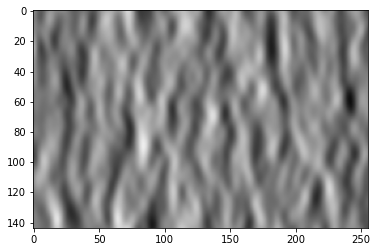

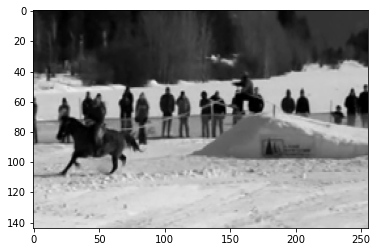

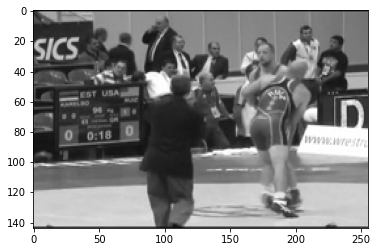

In [32]:
# Show frames from the movie.
from matplotlib import pyplot as plt

plt.imshow(frame1, aspect="auto")
plt.show()

plt.imshow(frame2, aspect="auto")
plt.show()

plt.imshow(frame3, aspect="auto")
plt.show()

### Two Photon Imaging

The two photon data contains 50000 imaging volumes collected at ~8.6 Hz, with six fields per volume.
The center of the volume was placed at the junction of primary visual cortex (VISp) and three higher visual areas, lateromedial area (VISlm), rostrolateral area (VISrl) and anterolateral area (VISal).

The imaging data for each field is stored in a `TwoPhotonSeries` object which can be accessed from `nwbfile.acqusition`.

The information about the imaging plane can accessed as `nwbfile.acquisition["TwoPhotonSeries1"].imaging_plane` or from `nwbfile.imaging_planes["ImagingPlane1"]`.

In [62]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            # The two photon imaging data for field 1
            two_photon_series1 = nwbfile.acquisition["TwoPhotonSeries1"]
            
            # The timestamps for the imaging data
            two_photon_series1_timestamps = nwbfile.acquisition["TwoPhotonSeries1"].timestamps[:]
            
            print(two_photon_series1.data.shape)
            frame1 = two_photon_series1.data[2200]
            
            
            # The two photon imaging data for field 2
            two_photon_series2 = nwbfile.acquisition["TwoPhotonSeries2"]
            frame2 = two_photon_series2.data[2200]
            
            # The two photon imaging data for field 3
            two_photon_series3 = nwbfile.acquisition["TwoPhotonSeries3"]
            frame3 = two_photon_series3.data[2200]

(50000, 248, 440)


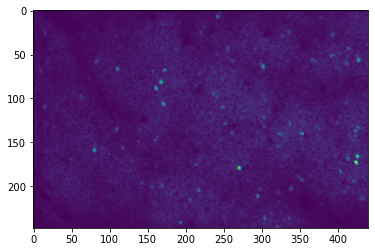

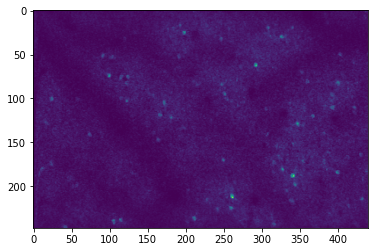

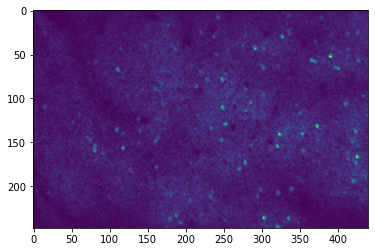

In [63]:
# Visualize the imaging data.

from matplotlib import pyplot as plt

plt.imshow(frame1, aspect="auto")
plt.show()

plt.imshow(frame2, aspect="auto")
plt.show()

plt.imshow(frame3, aspect="auto")
plt.show()


### Fluorescence traces

The "ophys" processing module contains the fluorescence traces, and image segmentations which can be accessed as `nwbfile.processing["ophys"]`. 

The fluorescence traces for each field are stored in `RoiResponseSeries` objects in a `Fluorescence` container within the "ophys" processing module as `nwbfile.processing["ophys"].data_interfaces`. 


In [38]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            fluorescence = nwbfile.processing["ophys"].data_interfaces["Fluorescence"]
            # The fluorescence traces for field 1 
            fluorescence.roi_response_series['RoiResponseSeries1']
            traces = fluorescence.roi_response_series['RoiResponseSeries1'].data[:]

The traces are stored in a 2D array where the first dimension is time, the second dimenion is the number of ROIs for this field.


In [39]:
traces.shape

(50000, 1410)

The image masks for each field are stored in `PlaneSegmentation` objects in an `ImageSegmentation` container within the "ophys" processing module.

In [41]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            image_segmentation = nwbfile.processing["ophys"].data_interfaces["ImageSegmentation"]
            # The plane segmentation for field 1 
            plane_segmentation1 = image_segmentation.plane_segmentations["PlaneSegmentation1"]
            # The image masks for field 1
            image_mask = image_segmentation.plane_segmentations["PlaneSegmentation1"]["image_mask"][:]
            print(image_mask.shape)
            
            # The image classification for field 1
            mask_type = image_segmentation.plane_segmentations["PlaneSegmentation1"]["mask_type"][:]
            print(mask_type[:10])

(1410, 440, 248)
['soma' 'artifact' 'soma' 'soma' 'soma' 'soma' 'soma' 'soma' 'soma' 'soma']


The functional data were co-registered with electron microscopy (EM) data. The structural identifiers of the matched cells are added as plane segmentation columns extracted from the CAVE database. To access the latest revision see the notebook [this notebook](https://github.com/cajal/microns_phase3_nda/blob/master/notebooks/Overview_Matched_Cell_Functional_Data.ipynb). The structural ids might not be present for all plane segmentations.

The "cave_ids" are the identifiers from the CAVE database (can be more than one for a given cell), "pt_position_x", "pt_position_y" and "pt_position_z" corresponds to the location in 4,4,40 nm voxels at a cell body for the cell, 
"pt_supervoxel_id" is the ID of the supervoxel from the watershed segmentation, "pt_root_id" is the ID of the segment/root_id from the Proofread Segmentation (v117).

In [55]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            image_segmentation = nwbfile.processing["ophys"].data_interfaces["ImageSegmentation"]
            # The plane segmentation for field 4
            plane_segmentation4 = image_segmentation.plane_segmentations["PlaneSegmentation4"][:]

plane_segmentation4

,image_mask,mask_type,cave_ids,pt_supervoxel_id,pt_root_id,pt_x_position,pt_y_position,pt_z_position
id,,,,,,,,
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",artifact,[nan],NaN,NaN,NaN,NaN,NaN
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",artifact,[nan],NaN,NaN,NaN,NaN,NaN
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[4310.0],1.120332e+17,8.646911e+17,343888.0,107008.0,15649.0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[nan],NaN,NaN,NaN,NaN,NaN
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[nan],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1400,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[nan],NaN,NaN,NaN,NaN,NaN
1401,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[6985.0],9.275343e+16,8.646911e+17,203737.0,116074.0,23591.0
1402,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",artifact,[nan],NaN,NaN,NaN,NaN,NaN


In [45]:
# The structural ids for field 4 
plane_segmentation4.dropna()

,image_mask,mask_type,cave_ids,pt_supervoxel_id,pt_root_id,pt_x_position,pt_y_position,pt_z_position
id,,,,,,,,
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[4310.0],1.120332e+17,8.646911e+17,343888.0,107008.0,15649.0
8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[2243.0],1.132301e+17,8.646911e+17,352640.0,111392.0,19327.0
12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[2244.0],1.136521e+17,8.646911e+17,355616.0,109728.0,20087.0
16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[8945.0],1.138626e+17,8.646911e+17,356899.0,105465.0,22206.0
26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[2245.0],1.116119e+17,8.646911e+17,340608.0,113856.0,18439.0
...,...,...,...,...,...,...,...,...
1381,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[2296.0],1.047158e+17,8.646911e+17,290656.0,113904.0,21738.0
1390,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[9303.0],9.233204e+16,8.646911e+17,200481.0,122465.0,17207.0
1394,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",soma,[4360.0],1.048560e+17,8.646911e+17,291504.0,110000.0,15556.0


The average and correlation images for each field are stored in `GrayscaleImage` objects in an `Images` container within the "ophys" processing module.

In [54]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
             
            # The average and correlation images for field 1
            segmentation_images1 = nwbfile.processing["ophys"].data_interfaces["SegmentationImages1"]
            # Load the average image data
            average_image = segmentation_images1.images["average"][:]
            # Load the correlation image data
            correlation_image = segmentation_images1.images["correlation"][:]

segmentation_images1       

SegmentationImages1 pynwb.base.Images at 0x140344371292768
Fields:
  description: Correlation and average images for field 1.
  images: {
    average <class 'pynwb.image.GrayscaleImage'>,
    correlation <class 'pynwb.image.GrayscaleImage'>
  }

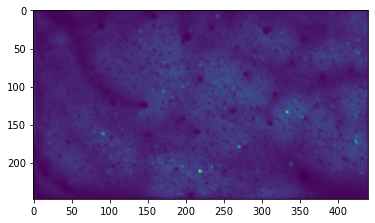

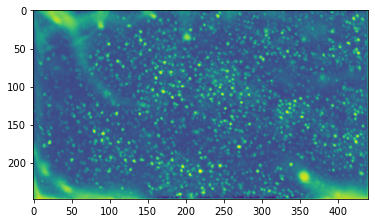

In [48]:
# Show the average and correlation images for field 1
plt.imshow(average_image)
plt.show()

plt.imshow(correlation_image)
plt.show()

### Behavior

The raw behavior data is composed of the velocity of the treadmill, eye movements and the pupil diameter data.

The velocity of the treadmill is stored in a `TimeSeries` object.

In [60]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            
            # Access the treadmill velocity
            treadmill_velocity = nwbfile.acquisition["treadmill_velocity"]
            # Acess the timestamps for the treadmill velocity
            treadmill_timestamps = treadmill_velocity.timestamps[:]
            
treadmill_velocity

treadmill_velocity pynwb.base.TimeSeries at 0x140344971444768
Fields:
  comments: no comments
  conversion: 0.01
  description: Cylindrical treadmill rostral-caudal position extracted at ~60-100 Hz and converted into velocity.
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps_unit: seconds
  unit: m/s

The position of the eye is stored in a `SpatialSeries` object which is stored in an `EyeTracking` container.

In [56]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()

            eye_position = nwbfile.acquisition["EyeTracking"].spatial_series["eye_position"]

eye_position

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


eye_position pynwb.behavior.SpatialSeries at 0x140344640942624
Fields:
  comments: no comments
  conversion: 1.0
  description: The x,y position of the pupil.The values are estimated in the relative pixel units.
  interval: 1
  offset: 0.0
  reference_frame: unknown
  resolution: -1.0
  timestamps: pupil_minor_radius pynwb.base.TimeSeries at 0x140344640945600
Fields:
  comments: no comments
  conversion: 1.0
  description: Minor radius extracted from the pupil tracking ellipse.The values are estimated in the relative pixel units.
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamp_link: (
    eye_position <class 'pynwb.behavior.SpatialSeries'>,
    pupil_major_radius <class 'pynwb.base.TimeSeries'>
  )
  timestamps_unit: seconds
  unit: px

  timestamps_unit: seconds
  unit: px

The pupil major and minor radius are stored as `TimeSeries` objects and they can be accessed from an `EyeTracking` container.

In [57]:
with file_system.open(s3_url, "rb") as virtual_file_stream:
    with File(virtual_file_stream, mode="r") as file:
        with NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()

            pupil_major_radius = nwbfile.acquisition['PupilTracking'].time_series["pupil_major_radius"]
            pupil_minor_radius = nwbfile.acquisition['PupilTracking'].time_series["pupil_minor_radius"]
            
pupil_major_radius

pupil_major_radius pynwb.base.TimeSeries at 0x140344639659456
Fields:
  comments: no comments
  conversion: 1.0
  description: Major radius extracted from the pupil tracking ellipse.The values are estimated in the relative pixel units.
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: pupil_minor_radius pynwb.base.TimeSeries at 0x140344639659360
Fields:
  comments: no comments
  conversion: 1.0
  description: Minor radius extracted from the pupil tracking ellipse.The values are estimated in the relative pixel units.
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamp_link: (
    eye_position <class 'pynwb.behavior.SpatialSeries'>,
    pupil_major_radius <class 'pynwb.base.TimeSeries'>
  )
  timestamps_unit: seconds
  unit: px

  timestamps_unit: seconds
  unit: px

### Time references

The timestamps in an NWB file should be in seconds with respect to the global start time of the session.
The original time references were relative to scan start which would have produced negative timestamps for the behavior data. Therefore, all times were shifted to the earliest behavioral timestamp.

In this file for instance, time `0.0` corresponds to the first timestamp for the treadmill velocity data while the two photon imaging started `10.899` seconds after.

In [61]:
treadmill_timestamps[0]

0.0

In [64]:
two_photon_series1_timestamps[0]

10.899238834999977

### View NWB files <a class="anchor" id="view-nwb"></a>

This section demonstrates how to visualize the contents of an NWB file interactively using `NWBWidgets`.

#### Visualize NWB file using Panel

Browse NWB files that are stored locally or remotely (e.g. DANDI) using `Panel`.
Use the GUI to navigate to the file (local) or use the "DANDI" button to stream the data from DANDI without having to download it.

In [67]:
from nwbwidgets.panel import Panel

Panel()

Panel(children=(HBox(children=(VBox(children=(RadioButtons(layout=Layout(width='100px'), options=('Local dir',…

Loading dandiset metadata:   0%|          | 0/220 [00:00<?, ?it/s]

## Downloading NWB files <a class="anchor" id="download-nwb"></a>

This section demonstrates how to download one of the sessions from this dataset using `dandi`. 

In [ ]:
from dandi.dandiapi import DandiAPIClient
from dandi.download import download as dandi_download

dandiset_id = "000402"
file_path = "sub-17797/sub-17797_ses-9+4_behavior+image+ophys.nwb" # file size ~67GB

# The folder where the file will be downloaded
dandiset_folder_path = "microns/nwbfiles/"

# The file path on DANDI
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    dandiset_url = asset.api_url

# Download the file
dandi_download(urls=dandiset_url, output_dir=dandiset_folder_path, get_metadata=True, get_assets=True)

In [ ]:
# Downloading all NWB files for this dandiset

# dandiset_url = "https://dandiarchive.org/dandiset/000402/draft"
# dandi_download(urls=dandiset_url, output_dir=dandiset_folder_path, get_metadata=True, get_assets=True)

#### Visualize an in-memory NWB file

Explore the NWB file using `nwb2widget`.

In [ ]:
from nwbwidgets import nwb2widget

nwb2widget(nwbfile)